Для построения более сложной модели и оптимизации гиперпараметров можно использовать GridSearchCV из sklearn.modelselection. GridSearchCV позволяет задать набор возможных гиперпараметров, которые он затем проверяет методом "перебора по сетке" - он обучает модель на каждой комбинации параметров и возвращает ту, на которой модель показала наилучший результат.

RMSE модели:  3.1160925650879676
RMSE константной модели:  181.6781183339868
Fitting 5 folds for each of 27 candidates, totalling 135 fits
RMSE лучшей модели:  3.056349552409119
registered: 1.538 +/- 0.032
casual: 0.108 +/- 0.003
hour: 0.000 +/- 0.000
atemp: 0.000 +/- 0.000
temp: 0.000 +/- 0.000
month: 0.000 +/- 0.000
weather: 0.000 +/- 0.000
humidity: 0.000 +/- 0.000
year: 0.000 +/- 0.000
workingday: 0.000 +/- 0.000
holiday: 0.000 +/- 0.000
season: -0.000 +/- 0.000
day: -0.000 +/- 0.000
windspeed: -0.000 +/- 0.000


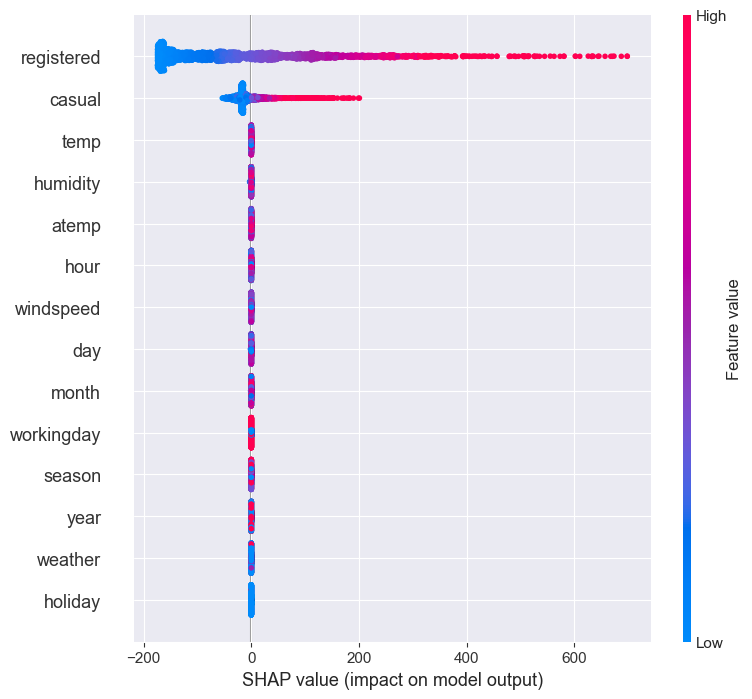

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
from sklearn.inspection import permutation_importance
import shap

# Загрузим данные
df = pd.read_csv('Yulu.csv')

# Преобразуем 'datetime' в datetime формат и извлечем отдельные признаки
df['datetime'] = pd.to_datetime(df['datetime'])
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour

# Теперь можем удалить 'datetime'
df = df.drop(columns=['datetime'])

# Извлечем векторы меток и признаков.
X = df.drop('count', axis=1)
y = df['count']

# Разделим данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучаем базовую модель
baseline_model = RandomForestRegressor(random_state=42)
baseline_model.fit(X_train, y_train)

# Предсказания модели на тестовом наборе
y_pred = baseline_model.predict(X_test)

# Вычисляем RMSE
rmse_model = sqrt(mean_squared_error(y_test, y_pred))
print("RMSE модели: ", rmse_model)

# Предсказания в виде среднего значения 'count'
y_mean = np.full(len(y_test), y_train.mean())

# Вычисляем RMSE для среднего значения
rmse_mean = sqrt(mean_squared_error(y_test, y_mean))
print("RMSE константной модели: ", rmse_mean)

# Подбор гиперпараметров с использованием GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [10, 20, 30],
    'random_state': [42]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Предсказания на тестовом наборе с лучшей моделью
y_pred_best = best_model.predict(X_test)
rmse_best_model = sqrt(mean_squared_error(y_test, y_pred_best))
print("RMSE лучшей модели: ", rmse_best_model)

# Важность признаков с использованием permutation importances
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
for i in perm_importance.importances_mean.argsort()[::-1]:
    print(f"{X.columns[i]}: {perm_importance.importances_mean[i]:.3f} +/- {perm_importance.importances_std[i]:.3f}")

# Важность признаков с использованием SHAP
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

GridSearchCV выбрал для нас наилучшие значения гиперпараметров для модели RandomForestRegressor:

- 'max_depth': None - это говорит о том, что деревья (дерево в случайном лесу) должны расширяться до тех пор, пока все листья не станут "чистыми" (то есть, не содержат элементов разных классов) или пока все элементы в листе не будут представлять собой меньше указанного числа образцов (min_samples_split).

- 'min_samples_leaf': 1 - минимальное количество элементов в листе дерева. Может быть настроено, чтобы избежать переобучения.

- 'min_samples_split': 2 - минимальное количество элементов, которое должно быть в узле, прежде чем он может быть разделен на поддеревья. Может быть также настроено, чтобы бороться с переобучением.

- 'n_estimators': 200 - количество деревьев в случайном лесу. На практике чем больше деревьев, которые мы добавляем, тем лучше происходит обобщение модели. Однако это усложняет модель, увеличивает время обучения и не всегда приводит к улучшению, особенно после определенной точки.


In [4]:
# Используя оптимальные гиперпараметры, обучим новую модель
model = RandomForestRegressor(
    n_estimators = grid_search.best_params_['n_estimators'],
    max_depth = grid_search.best_params_['max_depth'],
    min_samples_split = grid_search.best_params_['min_samples_split'],
    min_samples_leaf = grid_search.best_params_['min_samples_leaf'])
model.fit(X_train, y_train)

# Предсказания модели на тестовом наборе
y_pred = model.predict(X_test)

# Вычисляем RMSE
rmse_model = sqrt(mean_squared_error(y_test, y_pred))
print("RMSE модели: ", rmse_model)

# Вычисляем R2
r2_model = r2_score(y_test, y_pred)
print("R2 модели: ", r2_model)

RMSE модели:  3.0169085960703486
R2 модели:  0.9997242477304086


На старой модели показатель RMSE был: 3.0471543801299705
Значение текущей модели улучшилось, но не критично. ПРедполагается, что это из-за набора данных, которые специально были подготовлены для тренировки. Поэтому  и точность данных примерно одинаковая (ожинаковая, потому что 3 из 1000 - это небольшая ошибка, а уж о долях говорить тут вообще не имеет смысла)

In [ ]:
!pip install optuna

import optuna
from sklearn.model_selection import cross_val_score

# Замените вашу GridSearchCV на эту функцию
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200)
    max_depth = trial.suggest_int('max_depth', 10, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        random_state=42
    )

    return cross_val_score(
        model, X_train, y_train, cv=3, scoring='neg_mean_squared_error').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

# Handle the best_params
best_params = trial.params

# Используйте best_params для новых значений
best_model = RandomForestRegressor(
    n_estimators = best_params['n_estimators'],
    max_depth = best_params['max_depth'],
    min_samples_split = best_params['min_samples_split'],
    min_samples_leaf = best_params['min_samples_leaf'],
    random_state=42
)
best_model.fit(X_train, y_train)

# Predict with the fine-tuned model
y_pred_optuna = best_model.predict(X_test)

# Выводим результаты
rmse_optuna = sqrt(mean_squared_error(y_test, y_pred_optuna))
r2_optuna = r2_score(y_test, y_pred_optuna)

print("RMSE with Optuna: ", rmse_optuna)
print("R2 with Optuna: ", r2_optuna)

Для визуализации дерева используем библиотеку matplotlib

In [ ]:
import matplotlib.pyplot as plt

# Получим важности признаков
importances = best_model.feature_importances_

# Получим имена признаков
features = X.columns

# Сопоставим признаки и их важности
feature_importances = pd.Series(importances, index=features).sort_values(ascending=False)

# Выведем график
plt.figure(figsize=(10, 5))
feature_importances.plot(kind='bar')
plt.title("Feature importances")
plt.show()